In [1]:
import imports as im
import functions as fn
%matplotlib inline

2023-05-25 00:28:28.844887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
df = im.pd.read_csv('../data/data/train.csv')

Let's try to plot a simple spectrogram

In [3]:
whale_sample_file = '../data/data/train/train1.aiff'
whale_aiff = im.aifc.open(whale_sample_file, 'r')

print("Channels:", whale_aiff.getnchannels()) 
print("Frames:", whale_aiff.getnframes())
print("Frame rate (frames per second):", whale_aiff.getframerate())

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


Let's see the picture of spectrogram

/var/folders/88/c0pdndcx27s58d3c8hwgyz700000gn/T/ipykernel_9703/2253872114.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  whale_array = im.np.fromstring(whale_strSig, im.np.short).byteswap()


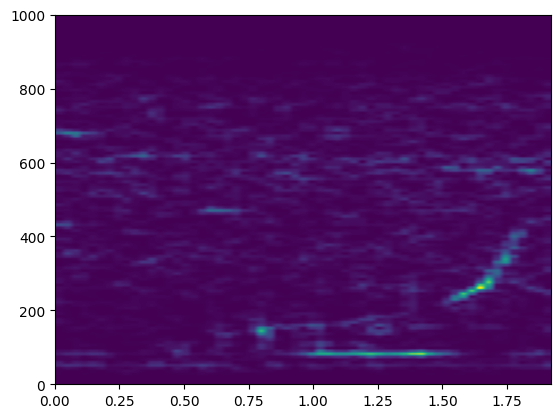

In [4]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = im.np.fromstring(whale_strSig, im.np.short).byteswap()

params = {'NFFT':256, 'Fs':2000, 'noverlap':192} # 'Fs':1000 for new
P, freqs, bins = im.mlab.specgram(whale_array, **params)

img = fn.PlotSpecgram(P, freqs, bins)

In [5]:
# Set path to directory with folders train and test
path_data = '../data/data/'
path_train_audio = '../data/data/train/'
path_target_train = '../data/data/train.csv'

Create datasets

- train : 80%
- val : 10%
- test : 10%

In [6]:
# Set path to directory with folders train and test
df = im.pd.read_csv('../data/data/train.csv')
path_train_img = '../datasets/pngs_from_wavs/'
path_train_img_noised = '../datasets/pngs_from_wavs_noised_002/'

train_index = int(len(df["clip_name"]) * 0.8)
val_index = train_index + int(len(df["clip_name"]) * 0.1)

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = fn.CreateKaggleDataset(df, train_index, val_index, path_train_img=path_train_img)

In [8]:
batch_size = 32

train_data = im.tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(batch_size).prefetch(buffer_size=100)

val_data = im.tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(buffer_size=100)

test_data = im.tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(buffer_size=100)

2023-05-25 00:29:01.751124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Link for NN model Xception
im.ssl._create_default_https_context = im.ssl._create_unverified_context

### Xception Network

In [17]:
# https://keras.io/guides/transfer_learning/

Xception_model = im.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=x_train.shape[-3:],
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [18]:
# Freeze the base_model
Xception_model.trainable = False

In [19]:
inputs = im.keras.Input(shape=x_train.shape[-3:])
x = inputs
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`.

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = im.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

In [20]:
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = Xception_model(x, training=False)
x = im.keras.layers.GlobalAveragePooling2D()(x)
x = im.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = im.keras.layers.Dense(200)(x)
outputs = im.keras.layers.Dense(1)(x)
xception = im.keras.Model(inputs, outputs)

xception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               409800    
                                                           

In [21]:
weights_file_layers = '../weights_xception/xception_weights_layers.h5'
xception.load_weights(weights_file_layers)

callback_layers = im.ModelCheckpoint(weights_file_layers, mode='max', save_best_only=True)

xception.compile(
    optimizer=im.keras.optimizers.Adam(),
    loss=im.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[im.keras.metrics.BinaryAccuracy()],
)

In [ ]:
epochs = 1
HistoryTop = xception.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_layers])

In [23]:
weights_file_finetun = '../weights_xception/xception_weights_finetun.h5'
callback_finetun = im.ModelCheckpoint(weights_file_finetun, mode='max', save_best_only=True)
# xception.load_weights(weights_file_finetun)

# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
Xception_model.trainable = True


xception.summary()

xception.compile(
    optimizer=im.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=im.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[im.keras.metrics.BinaryAccuracy()],
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 146, 139, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 146, 139, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 200)               409800    
                                                           

In [ ]:
epochs = 1
HistoryFinetun = xception.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[callback_finetun])

If we want to use model with trained weights

In [17]:
weights_file = '../weights_xception/xception_weights_finetun.h5'
xception.load_weights(weights_file)
xception.trainable = False

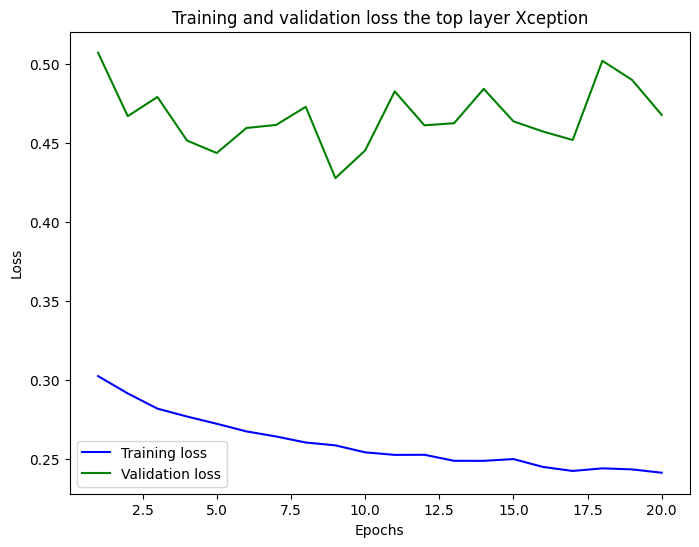

In [57]:
LossTop = HistoryTop.history['loss']
ValLossTop = HistoryTop.history['val_loss']

AccTop = HistoryTop.history['binary_accuracy']
ValAccTop = HistoryTop.history['val_binary_accuracy']

EpochsTop = range(1, len(LossTop) + 1)

In [ ]:
fn.PlotLossAcc(TrainData=LossTop, ValData=ValLossTop, Epochs=EpochsTop,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Loss', title='Training and validation loss the top layer Xception',
            ColTrain='blue', ColVal='green', filename="../images/loss_top.pdf")

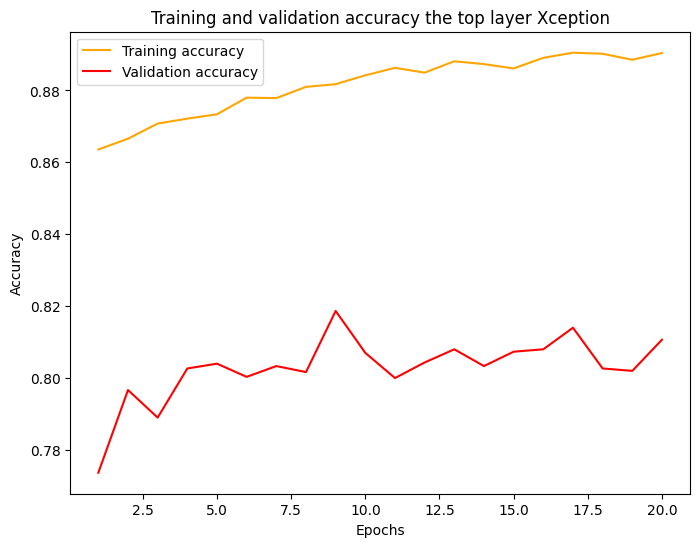

In [58]:
fn.PlotLossAcc(TrainData=AccTop, ValData=ValAccTop, Epochs=EpochsTop,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy the top layer Xception',
            ColTrain='orange', ColVal='red', filename="../images/accuracy_top.pdf")

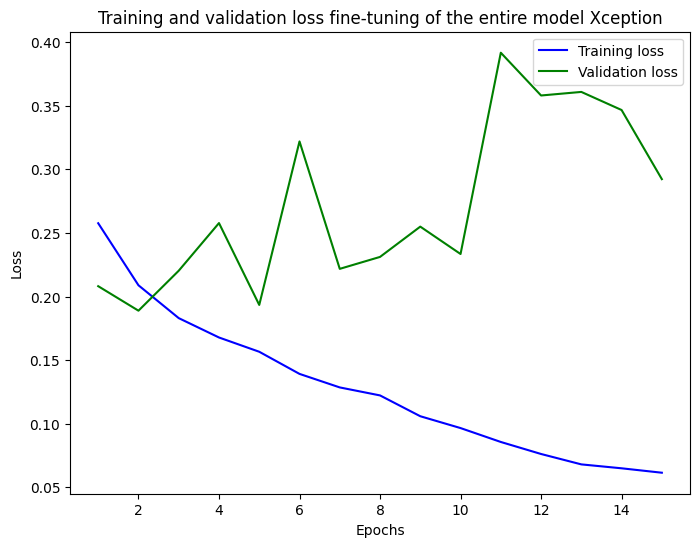

In [59]:
LossFine = HistoryFinetun.history['loss']
ValLossFine = HistoryFinetun.history['val_loss']

AccFine = HistoryFinetun.history['binary_accuracy']
VallAccFine = HistoryFinetun.history['val_binary_accuracy']

EpochsFine = range(1, len(LossFine) + 1)

In [ ]:
fn.PlotLossAcc(TrainData=LossFine, ValData=ValLossFine, Epochs=EpochsFine,
            TrainLabel='Training loss', ValLabel='Validation loss',
            yLabel='Loss', title='Training and validation loss fine-tuning of the entire model Xception',
            ColTrain='blue', ColVal='green', filename="../images/loss_fine.pdf")

In [ ]:
fn.PlotLossAcc(TrainData=AccFine, ValData=VallAccFine, Epochs=EpochsFine,
            TrainLabel='Training accuracy', ValLabel='Validation accuracy',
            yLabel='Accuracy', title='Training and validation accuracy fine-tuning of the entire model Xception',
            ColTrain='orange', ColVal='red', filename="../images/accuracy_fine.pdf")

Accuracy with trained weights is 97%. With noised data - 89.26%

In [22]:
score_x = xception.evaluate(test_data, verbose=0)
print("Xception test loss:", score_x[0])
print("Xception test accuracy:", score_x[1])

2023-03-24 12:11:51.081643: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Xception test loss: 0.20475991070270538
Xception test accuracy: 0.9733333587646484
